In [32]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [33]:
def extract_columns(raw_data, rows):
    return [raw_data[col].values[:rows] for col in raw_data.columns[1:]]

def check_for_sufficient_data(pos_data, neg_data, num_of_test_data):
    if min(len(pos_data),len(neg_data)) < num_of_test_data:
        print ("Not enough positive/negative data points")
        return False
    else:
        return True

def create_test_train_datasets(pos_data, neg_data, num_of_test_data):            
    # Shuffle data
    np.random.shuffle(pos_data)
    np.random.shuffle(neg_data)

    n = int(num_of_test_data/2)
 
    test_data = np.vstack((pos_data[:n],neg_data[:n]))
    train_data = np.vstack((pos_data[n:],neg_data[n:]))

    test_labels = np.hstack((np.ones(n),np.zeros(n)))
    train_labels = np.hstack((np.ones(len(pos_data)-n),np.zeros(len(neg_data)-n)))

    return test_data, test_labels, train_data, train_labels 

def load_data():
    raw_data_skin = pd.read_csv('2016skin.csv', sep=';', decimal='.')
    raw_data_material = pd.read_csv('2016material.csv', sep=';', decimal='.')
    raw_data_material_fake = pd.read_csv('2016material-fake.csv', sep=';', decimal='.')

    data_skin = np.array(extract_columns(raw_data_skin,1021))
    data_not_skin = np.array(extract_columns(raw_data_material,1021) + extract_columns(raw_data_material_fake,1021))
    
    if check_for_sufficient_data(data_skin, data_not_skin, 100):
        return create_test_train_datasets(data_skin, data_not_skin, 100)

In [34]:
# Neural Network Model
def run_nn_model():
    # Define model
    input_data = Input(shape=(1021,))
    x = Dense(1021, activation='relu')(input_data)
    output_data = Dense(1, activation='sigmoid')(x)
    nn_model = Model(input_data, output_data)

    # Compile model
    nn_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.000001), metrics=['accuracy'])

    # Train model
    weights = compute_class_weight('balanced',np.array([0,1]),train_labels)
    nn_model.fit(train_data, train_labels, batch_size=5, epochs=10, class_weight={0:weights[0],1:weights[1]}, verbose=1)
    
    # Get predictions
    predicted_labels = nn_model.predict(test_data)
    predicted_labels = np.array([i > 0.5 for i in predicted_labels])
    
    del nn_model
    return predicted_labels

# Support Vector Machine Model
def run_svm_model():
    # Define model
    svm_model = svm.SVC(C=1000, kernel='linear')

    # Train model
    svm_model.fit(train_data, train_labels)

    # Get predictions
    predicted_labels = svm_model.predict(test_data)
    predicted_labels = np.array([i > 0.5 for i in predicted_labels])
    
    del svm_model
    return predicted_labels

## Data Classification using Neural Networks

In [ ]:
# Set random seed for repeatibility
np.random.seed(0)

In [10]:
# Load data
test_data, test_labels, train_data, train_labels = load_data()

In [16]:
predicted_labels = run_nn_model()

/home/carlo/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1], y=[1. 1. 1. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Epoch 1/10
276/276 [==============================] - 3s 9ms/step - loss: 0.5822 - accuracy: 0.9260
Epoch 2/10
276/276 [==============================] - 2s 8ms/step - loss: 0.1013 - accuracy: 0.9695
Epoch 3/10
276/276 [==============================] - 2s 9ms/step - loss: 0.0879 - accuracy: 0.9790
Epoch 4/10
276/276 [==============================] - 2s 8ms/step - loss: 0.0796 - accuracy: 0.9797
Epoch 5/10
276/276 [==============================] - 2s 9ms/step - loss: 0.0740 - accuracy: 0.9819
Epoch 6/10
276/276 [==============================] - 2s 9ms/step - loss: 0.0682 - accuracy: 0.9833
Epoch 7/10
276/276 [==============================] - 3s 9ms/step - loss: 0.0642 - accuracy: 0.9869
Epoch 8/10
276/276 [==============================] - 3s 9ms/step - loss: 0.0613 - accuracy: 0.9840
Epoch 9/10
276/276 [==============================] - 2s 9ms/step - loss: 0.0583 - accuracy: 0.9848
Epoch 10/10
276/276 [==============================] - 3s 10ms/step - loss: 0.0563 - accuracy: 0.986

NN PERFORMANCE
precision: 0.98
recall: 0.98
confusion matrix:


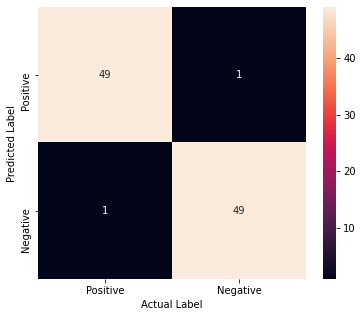

In [28]:
print ("NN PERFORMANCE")

print ("precision:",precision_score(test_labels, predicted_labels, labels=[1,0]))
print ("recall:",recall_score(test_labels, predicted_labels, labels=[1,0]))
print ("confusion matrix:")

array = confusion_matrix(test_labels, predicted_labels, labels=[1,0])
df_cm = pd.DataFrame(array, 
                     index = ["Positive", "Negative"],
                     columns = ["Positive", "Negative"])

plt.figure(figsize = (6,5))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.show()

## Data Classification using Support Vector Machines

In [37]:
# Set random seed for repeatibility
np.random.seed(0)

In [38]:
# Load data
test_data, test_labels, train_data, train_labels = load_data()

In [39]:
predicted_labels = run_svm_model()

SVM PERFORMANCE
precision: 1.0
recall: 1.0
confusion matrix:


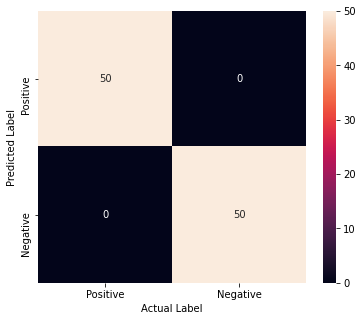

In [40]:
print ("SVM PERFORMANCE")

print ("precision:",precision_score(test_labels, predicted_labels, labels=[1,0]))
print ("recall:",recall_score(test_labels, predicted_labels, labels=[1,0]))
print ("confusion matrix:")

array = confusion_matrix(test_labels, predicted_labels, labels=[1,0])
df_cm = pd.DataFrame(array, 
                     index = ["Positive", "Negative"],
                     columns = ["Positive", "Negative"])

plt.figure(figsize = (6,5))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.show()